# Optimization techniques Lab. 2: Stochastic global optimization
## Introduction
**Goal.** The goal of this laboratory is to study the application of stochastic global search algorithms on different benchmark functions.

We will study two methods: DIRECT and Basin-hopping. Moreover, we will study the effect of their parameters on the outcome of the search. 

**Getting started.** The following code cell contains the core functions that we will use. Hence, remember to run it every time the Colab runtime is reconnected.

You can find a wrapper function for the  two algorithm, together with a wrapper for the benchmark function. 

The constructor for the *OptFun* class takes in input a benchmark function (we will see later what functions are available). The relevant methods  are 4:
1.   *Minima*: return a list of the minimum of the function. The position can be obtained by the parameter *position* and the function value from the *score* parameter.
2.   *Bounds*: returns where the function is defined
3.   *Heatmap*: show a heatmap of the function highlighting the points visited by the local search
4.   *plot*: show the trend of the points visited by the local search. 

Each instance of *OptFun* stores the history of the point at which the function has been evaluated. The history is never cleaned and can be obtained through *OptFun.history*. Hence, if you reuse the class instance remember to clean the history (*OptFun.history = list()*).

---

The benchmark functions available comes from the *benchmark_functions* library (imported as *bf*). 
The complete list of functions available can be found at this [link](https://gitlab.com/luca.baronti/python_benchmark_functions).





In [1]:
!pip install benchmark_functions
!pip install scipydirect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 3.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 51 kB 4.4 MB/s 
  Created wheel for scipydirect: filename=scipydirect-1.4-cp37-cp37m-linux_x86_64.whl size=121309 sha256=723609a99532ae2e616dbe252eb293d5d64682899600c35301c25ef55d18496d
  Stored in directory: /root/.cache/pip/wheels/d1/55/82/46e725d4a6d6382c096f4d4f557f3e89884858d865e5e24383
Successfully built scipydirect


In [2]:
import importlib
import numpy as np
from copy import deepcopy
import benchmark_functions as bf
from matplotlib import pyplot as plt
from scipy.optimize import basinhopping as spbasinhopping
from scipydirect import minimize as spdirect


class OptFun():
    def __init__(self, wf):
        self.f = wf
        self.history = []
        
    def __call__(self, x0):
        self.history.append(deepcopy(x0))
        return self.f(x0)

    def minima(self):
        return self.f.minima()
        
    def bounds(self):
        return self._convert_bounds(self.f.suggested_bounds())

    def heatmap(self, fn = None):
        plt.clf()
        resolution = 50
        fig = plt.figure()
        fig.canvas.set_window_title('Benchmark Function: '+self.f._name)
        fig.suptitle(self.f._name)
        bounds_lower, bounds_upper = self.f.suggested_bounds()
        x = np.linspace(bounds_lower[0], bounds_upper[0], resolution)
        if self.f._n_dimensions>1:
            y = np.linspace(bounds_lower[1], bounds_upper[1], resolution)
            X, Y = np.meshgrid(x, y)
            Z = np.asarray([[self.f((X[i][j],Y[i][j])) for j in range(len(X[i]))] for i in range(len(X))])

        plt.contour(x,y,Z,15,linewidths=0.5,colors='k') # hight lines
        plt.contourf(x,y,Z,15,cmap='viridis', vmin=Z.min(), vmax=Z.max()) # heat map
        plt.xlabel('x')
        plt.ylabel('y')
        cbar = plt.colorbar()
        cbar.set_label('z')
        if len(self.history)>0:	# plot points
            xdata = [x[0] for x in self.history]
            ydata = [x[1] for x in self.history]
            plt.plot(xdata, ydata, "or-", markersize=2, linewidth=2)
        if fn is None:
            plt.show()
        else:
            plt.savefig(fn, dpi=400)

    def plot(self):
        plt.clf()
        values = [self.f(v) for v in self.history]
        min = func.minima()[0].score
        plt.plot(values)
        plt.axhline(min, color="r", label="optimum")
        plt.legend()
        plt.show()

    def _convert_bounds(self, bounds):
        new_bounds= []
        for i in range(len(bounds[0])):
            new_bounds.append((bounds[0][i], bounds[1][i]))
        return new_bounds
    
    def current_calls(self):
        return len(self.history)


def direct(f: OptFun, eps: float = 1e-4, maxiter: int = 1000):
    """
    Optimizes a function by using the DIRECT algorithm.

    - f: function to optimize, an instance of OptFun
    - eps: regulates the trade-off between local and global exploration.
            The smaller the eps, the more local the search process is.
            The higher the eps, the more global the search process becomes.
    - maxiter: maximum number of iterations
    """
    bounds = f.bounds()
    return spdirect(
        func,
        bounds=bounds,
        eps=eps,
        maxf=maxiter,
        fglobal=-1e100,
        fglper=0.001,
        volper=-1.0,
        sigmaper=-1.0
    )


def basinhopping(
    f: OptFun,
    x0: np.ndarray, 
    T: float = 1.0,
    stepsize: float = 0.5, 
    stepsize_interval: int = 50,
    step_update: float = 0.9,
    maxiter: int = 1000):
    """
    Optimizes a function by using the Basin-hopping algorithm.

    - f: function to optimize, an instance of OptFun
    - x0: starting point for the search process
    - T: temperature parameter
    - stepsize: maximum step size for random displacement
    - stepsize_interval: interval for the update of the step size
    - step_update: update factor for the step size 
    - maxiter: maximum number of iterations
    """
    return spbasinhopping(
        f,
        x0, 
        niter=maxiter, 
        T=T, 
        stepsize=stepsize,
        minimizer_kwargs=None,
        take_step=None,
        accept_test=None,
        callback=None,
        interval=stepsize_interval,
        disp=False,
        niter_success=None,
        seed=None,
    )



# Ex 1: DIRECT
---
In this first exercise we will use DIRECT as a search algorithm
## Questions
- How does the eps parameter influence the search process?
- How does the number of maximum iterations influence the search process?

<Figure size 432x288 with 0 Axes>

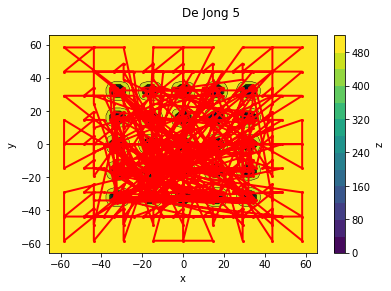

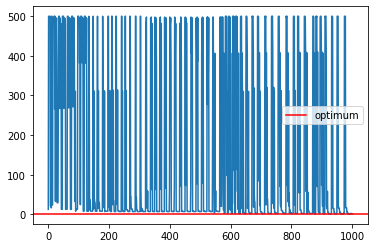

In [3]:
func = OptFun(bf.DeJong5())
a = direct(func,1e-4, 1000)
func.heatmap()
func.plot()

# Ex 2: Basin-hopping
---
In this first exercise we will use Basin-hopping as a search algorithm
## Questions
- What is the influence of the following parameters on the search process?
    - T
    - stepsize 
    - stepsize_interval
    - step_update
- How does the number of maximum iterations influence the search process?
- How does the starting point influence the search process?

<Figure size 432x288 with 0 Axes>

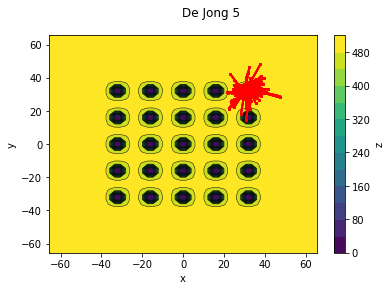

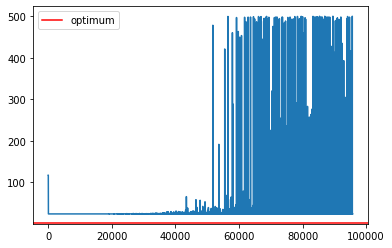

In [5]:
func = OptFun(bf.DeJong5())
a = basinhopping(func, [30,30])
func.heatmap()
func.plot()

## General questions
- How do the approaches seen in today's lab compare to the one seen in the previous lab?